# 11주차 실습: 합성 데이터 & RAG 평가

이 노트북은 11주차 수업 **“합성 데이터 & RAG 평가”**를 위한 실습 템플릿입니다.

## 목표
- 작은 문서 집합(문단들)을 준비하고,
- 그 위에서 **평가용 Q&A(합성 데이터 포함)**를 구성한 뒤,
- 간단한 TF-IDF 기반 검색기(Retriever)를 만들어
- **Recall@k** 지표로 RAG Retrieval 품질을 평가해봅니다.

👉 이 노트북은 **로컬/수업 환경에서 바로 실행 가능한 예시 코드**를 포함하고, LLM을 사용하는 부분은 주석/템플릿으로 제공됩니다.


## 1. 환경 준비

필요 패키지:
- `pandas`
- `scikit-learn`
- `matplotlib`
- (선택) `nlpaug`, `nltk`

로컬 환경에서 아래 명령으로 설치할 수 있습니다:

```bash
pip install pandas scikit-learn matplotlib nlpaug nltk
```


In [20]:
# (선택) 패키지 설치 셀 — 이미 설치되어 있다면 실행하지 않아도 됩니다.
!pip install -q pandas scikit-learn matplotlib nlpaug nltk


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 2. 기본 라이브러리 임포트

RAG 평가에 사용할 기본 라이브러리를 불러옵니다.

In [21]:
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

import random
import json

import nltk

# 품사 태거 + wordnet 다운로드
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')  # 동의어 사전용



[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sjcha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sjcha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/sjcha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sjcha/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 3. 예시 문서(문단) 준비

우선 실습을 위해 **간단한 문단 몇 개**를 직접 정의합니다.

실제 과제에서는:
- 강의노트 일부,
- 위키 문서 일부,
- 본인이 관심 있는 도메인 텍스트

등으로 자유롭게 교체하면 됩니다.

In [22]:
documents: List[Dict] = [
    {
        "doc_id": 0,
        "text": "RAG는 Retrieval-Augmented Generation의 약자로, 검색과 생성을 결합한 구조를 의미한다. 먼저 Retriever가 관련 문서를 찾고, 그 다음에 Generator가 해당 문서를 참고하여 답변을 생성한다.",
    },
    {
        "doc_id": 1,
        "text": "Retriever는 사용자의 질문과 유사한 문서를 검색하는 모듈이다. 보통 BM25, TF-IDF, 혹은 벡터 검색을 사용하여 문서의 관련성을 계산한다.",
    },
    {
        "doc_id": 2,
        "text": "Generator는 LLM과 같이 자연어를 생성할 수 있는 모델이다. 주어진 문맥을 기반으로 답변을 생성하며, 프롬프트 설계와 컨텍스트 품질에 따라 성능이 크게 달라진다.",
    },
    {
        "doc_id": 3,
        "text": "Synthetic Data는 사람이 직접 수집하거나 라벨링한 데이터가 아니라, 모델이나 알고리즘이 인공적으로 만들어낸 데이터를 의미한다. LLM을 사용해 Q&A를 대량으로 생성하는 것도 Synthetic Data의 한 예이다.",
    },
    {
        "doc_id": 4,
        "text": "Recall@k는 정답 문서가 검색 결과 상위 k개 안에 포함될 확률을 의미한다. RAG 시스템에서는 정답 문서를 Retriever가 가져오는지 여부를 확인하기 위해 자주 사용된다.",
    },
]

len(documents), documents[0]

(5,
 {'doc_id': 0,
  'text': 'RAG는 Retrieval-Augmented Generation의 약자로, 검색과 생성을 결합한 구조를 의미한다. 먼저 Retriever가 관련 문서를 찾고, 그 다음에 Generator가 해당 문서를 참고하여 답변을 생성한다.'})

## 4. TF-IDF 기반 Retriever 구축

간단한 RAG 평가를 위해, 문단 텍스트를 **TF-IDF 벡터**로 변환하고, 질문과의 **코사인 유사도**로 검색하는 Retriever를 만듭니다.

In [23]:
corpus = [d["text"] for d in documents]

vectorizer = TfidfVectorizer()
doc_vectors = vectorizer.fit_transform(corpus)

doc_vectors.shape

(5, 97)

In [24]:
def retrieve(question: str, k: int = 3) -> List[int]:
    """질문을 입력하면 상위 k개의 doc_id 리스트를 반환하는 간단한 Retriever."""
    q_vec = vectorizer.transform([question])
    sims = cosine_similarity(q_vec, doc_vectors)[0]
    topk_indices = sims.argsort()[::-1][:k]
    return topk_indices.tolist()

sample_q = "Retriever의 역할은 무엇인가요?"
print("질문:", sample_q)
print("상위 3개 doc_id:", retrieve(sample_q, k=3))

질문: Retriever의 역할은 무엇인가요?
상위 3개 doc_id: [4, 3, 2]


## 5. 평가용 Q&A 세트 구성

실습을 단순하게 하기 위해, 먼저 **직접 정의한 Q&A**로 시작합니다.

실제 과제에서는:
- LLM을 사용해 문단에서 Q&A를 생성하거나,
- 사람이 작성한 Q&A를 조금 더 늘려서 사용하면 됩니다.

In [25]:
eval_qas: List[Dict] = [
    {
        "question": "RAG는 무엇의 약자인가요?",
        "gold_doc_id": 0,
    },
    {
        "question": "Retriever는 어떤 역할을 하나요?",
        "gold_doc_id": 1,
    },
    {
        "question": "Generator는 무엇을 담당하나요?",
        "gold_doc_id": 2,
    },
    {
        "question": "Synthetic Data는 무엇을 의미하나요?",
        "gold_doc_id": 3,
    },
    {
        "question": "Recall@k는 무엇을 나타내는 지표인가요?",
        "gold_doc_id": 4,
    },
]

len(eval_qas), eval_qas[0]

(5, {'question': 'RAG는 무엇의 약자인가요?', 'gold_doc_id': 0})

## 6. (선택) `nlpaug`로 질문 변형(Paraphrase/증강) 해보기

이 섹션은 **선택 사항**입니다. `nlpaug`를 이용해 기존 질문을 약간 변형한 버전을 만들어,
RAG가 다양한 표현에도 잘 동작하는지 확인할 수 있습니다.

설치가 안 되어 있거나, 환경에 문제가 있으면 이 셀을 건너뛰어도 됩니다.

In [26]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug(aug_src='wordnet')

base_question = "RAG는 무엇의 약자인가요?"
print("원본 질문:", base_question)
print("증강 예시:")
for i in range(3):
    print(f"  {i+1}.", aug.augment(base_question))

원본 질문: RAG는 무엇의 약자인가요?
증강 예시:
  1. ['RAG는 무엇의 약자인가요?']
  2. ['RAG는 무엇의 약자인가요?']
  3. ['RAG는 무엇의 약자인가요?']


위 예시는 라이브러리 특성상 **영어에서 더 잘 동작**하지만,
실습에서는 한국어 질문을 살짝 바꿔보는 데에도 응용해 볼 수 있습니다.

또는 LLM(예: GPT-4, 로컬 LLM)을 사용해 직접 paraphrase를 생성해도 됩니다.

## 7. Recall@k 계산 함수 구현

이제 평가용 Q&A 리스트(`eval_qas`)와 `retrieve()` 함수를 이용해,
**Recall@k** 지표를 계산하는 함수를 작성합니다.

In [27]:
def recall_at_k(eval_qas: List[Dict], k: int = 3) -> float:
    hits = 0
    total = len(eval_qas)
    for row in eval_qas:
        q = row["question"]
        gold = row["gold_doc_id"]
        retrieved = retrieve(q, k=k)
        if gold in retrieved:
            hits += 1
    return hits / total if total > 0 else 0.0

for k in [1, 3, 5]:
    print(f"Recall@{k} = {recall_at_k(eval_qas, k=k):.3f}")

Recall@1 = 1.000
Recall@3 = 1.000
Recall@5 = 1.000


## 8. Recall@k 시각화 (막대그래프)

간단한 막대그래프로 k에 따른 Recall 변화를 시각화해 봅니다.

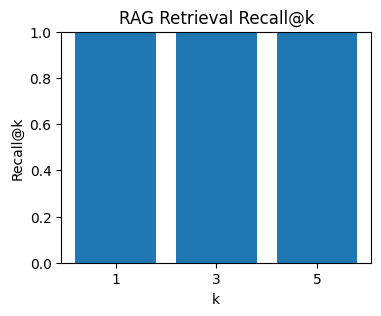

In [16]:
ks = [1, 3, 5]
recalls = [recall_at_k(eval_qas, k=k) for k in ks]

plt.figure(figsize=(4, 3))
plt.bar([str(k) for k in ks], recalls)
plt.xlabel("k")
plt.ylabel("Recall@k")
plt.ylim(0, 1.0)
plt.title("RAG Retrieval Recall@k")
plt.show()

## 9. (템플릿) LLM 기반 Synthetic QA를 넣고 싶을 때

수업/과제에서는 OpenAI, Azure OpenAI, 로컬 LLM 등 **외부 LLM**을 사용해
문단에서 자동으로 Q&A를 생성할 수도 있습니다.

이 노트북에서는 실제 API 호출 코드는 넣지 않고, **함수 인터페이스만 템플릿**으로 제공합니다.
환경에 맞게 구현해서 사용하면 됩니다.

In [28]:
def generate_synthetic_qa_from_doc(doc_text: str, n_questions: int = 3) -> List[Dict]:
    """LLM을 사용해 doc_text에서 Q&A를 생성한다고 가정한 템플릿 함수.

    실제 구현 시에는 OpenAI/로컬 LLM API를 호출하여
    [{"question": ..., "answer": ...}, ...] 형태로 반환하면 됩니다.
    여기서는 데모를 위해 간단한 더미 데이터를 생성합니다.
    """
    dummy_qas = []
    for i in range(n_questions):
        q = f"(DEMO) 이 문단 내용에 대한 질문 {i+1}은 무엇인가요?"
        a = f"(DEMO) 문단 내용을 요약한 예시 정답 {i+1}입니다."
        dummy_qas.append({"question": q, "answer": a})
    return dummy_qas

demo_doc = documents[0]["text"]
generate_synthetic_qa_from_doc(demo_doc, n_questions=2)

[{'question': '(DEMO) 이 문단 내용에 대한 질문 1은 무엇인가요?',
  'answer': '(DEMO) 문단 내용을 요약한 예시 정답 1입니다.'},
 {'question': '(DEMO) 이 문단 내용에 대한 질문 2은 무엇인가요?',
  'answer': '(DEMO) 문단 내용을 요약한 예시 정답 2입니다.'}]

## 10. (선택) 문서/QA를 CSV/JSON으로 내보내기 & 불러오기

다른 팀원과 데이터를 공유하거나, 나중에 다시 실험하기 쉽도록
문서/QA를 파일로 저장해 둘 수 있습니다.

In [18]:
import os
from pathlib import Path

DATA_DIR = Path("week11_data")
DATA_DIR.mkdir(exist_ok=True)

with open(DATA_DIR / "documents.json", "w", encoding="utf-8") as f:
    json.dump(documents, f, ensure_ascii=False, indent=2)

df_qas = pd.DataFrame(eval_qas)
df_qas.to_csv(DATA_DIR / "eval_qas.csv", index=False)

print("저장 완료:")
print("-", DATA_DIR / "documents.json")
print("-", DATA_DIR / "eval_qas.csv")

저장 완료:
- week11_data/documents.json
- week11_data/eval_qas.csv


In [19]:
with open(DATA_DIR / "documents.json", "r", encoding="utf-8") as f:
    loaded_docs = json.load(f)

df_loaded_qas = pd.read_csv(DATA_DIR / "eval_qas.csv")

print("불러온 문서 개수:", len(loaded_docs))
print("불러온 QA 샘플:")
df_loaded_qas.head()

불러온 문서 개수: 5
불러온 QA 샘플:


,question,gold_doc_id
0,RAG는 무엇의 약자인가요?,0
1,Retriever는 어떤 역할을 하나요?,1
2,Generator는 무엇을 담당하나요?,2
3,Synthetic Data는 무엇을 의미하나요?,3
4,Recall@k는 무엇을 나타내는 지표인가요?,4


## 11. 리포트 템플릿 (과제용)

아래는 과제 제출 시 사용할 수 있는 **Markdown 리포트 템플릿** 예시입니다.
필요에 따라 수정해서 사용하세요.

```markdown
# 11주차 RAG Retrieval 평가 리포트

## 1. 데이터 설명
- 문서 출처: (예: 강의노트 11주차 내용 요약본)
- 문단 수: (예: 7개)
- 평가용 QA 수: (예: 12개)
- QA 생성 방법: (예: 직접 작성 6개 + LLM 기반 Synthetic 6개)

## 2. 실험 설정
- 검색 방식: TF-IDF (scikit-learn)
- k 값: 1, 3, 5
- 사용 언어: 한국어

## 3. 실험 결과

| 설정      | Recall@1 | Recall@3 | Recall@5 |
|-----------|----------|----------|----------|
| 기본 TF-IDF | 0.42     | 0.75     | 0.83     |

## 4. 인사이트
- k를 1에서 3으로 늘렸을 때 Recall이 크게 증가했다.
- 대부분의 질문에서 정답 문서는 3등 안에는 있었지만, 1등으로 올라오지 못하는 경우가 있었다.
- 향후에는 임베딩 기반 검색(SentenceTransformer)이나 BM25를 사용해 비교해 보고 싶다.
```

## 12. 마무리

이 노트북을 통해 다음 단계를 경험했습니다.
1. 작은 문단 집합(`documents`)을 정의하고,
2. TF-IDF 기반 Retriever(`retrieve`)를 만들고,
3. 평가용 Q&A(`eval_qas`)를 구성한 뒤,
4. **Recall@k** 지표로 Retrieval 품질을 측정했습니다.

실제 프로젝트 또는 기말 프로젝트에서는:
- 더 많은 문서/질문을 사용하고,
- LLM 기반 Synthetic Q&A를 도입하고,
- 벡터 검색/임베딩/하이브리드 검색으로 확장해 볼 수 있습니다.

👉 이 노트북을 복사·수정하여 **자신만의 RAG 평가 파이프라인**을 설계해 보세요. 🚀
